In [18]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.integrate import odeint
import pandas as pd
from lmfit import Parameters, minimize, report_fit
import requests

Nma=36.89e6 #morocco
Nsp=46.7e6 #Spain
Nde=83.7e6 #Germany
Nalg=43.8e6 #1lgeria
Nmx=128.86e6 #mexico
Nfr=65.26e6 #france
Nit=60.464e6#Italy
Nch=1.439196e9#Italy

N=Nma

In [19]:
def getCountryData(country,N,m):
  r = requests.get('https://api.covid19api.com/dayone/country/'+country)
  res=r.json()
  df=pd.DataFrame(res)
  if country=="china":
      df=df[df["Province"]=="Hubei"]
  else:
      df=df[df["Province"]==""]
  df.to_csv('ma.csv',index=False)
  c=np.array(df['Confirmed'])[:m]
  print(c)
  a=np.array(df['Active'])
  r=np.array(df['Recovered'])
  d=np.array(df['Deaths'])
  #N=np.max(c)
  #N=21e6
  s=N-a-r-d
  y0=[s[0]-a[0],a[0],r[0],d[0]]
  data=np.array([s[1:m],a[1:m],r[1:m],d[1:m]])
  return y0,data,c
y0,data,ac=getCountryData("MA",N,90)
print(y0)
p=1


[   1    1    1    2    2    2    2    2    3    5    6    7   17   28
   29   38   49   63   77   96  115  143  170  225  275  345  402  479
  556  617  654  708  791  919 1021 1120 1184 1275 1374 1448 1545 1661
 1763 1888 2024 2283 2564 2685 2855 3046 3209 3446 3568 3758 3897 4065
 4120 4252 4321 4423 4569 4729 4903 5053 5219 5408 5548 5711 5910 6063
 6281 6418 6512 6607 6652 6741 6870 6952 7023 7133 7211 7332 7406 7433
 7532 7577 7601 7643 7714 7780]
[36889998.0, 1, 0, 0]


In [20]:
# SIRD Model
## Input:
### y: valeur actuel de S I R et D
### t: L'instant temps
### N: Population total
### beta:
### gamma: 
### sigma:
## Output
### la variation de S I R et D

def deriv(y, x, N, beta, gamma, sigma,p):
    S, I, R , D = y
    dSdt = -beta * I *(S/ N)**p
    dIdt = beta * I * (S/ N)**p - (gamma +sigma) * I
    dRdt = gamma * I
    dDdt = sigma * I
    return dSdt, dIdt, dRdt , dDdt


#Test de la fonction deriv
p=1
deriv([10, 1, 0, 0],1,N, 1, 0.2, 0.1,1)



(-2.7107617240444563e-07, -0.29999972892382765, 0.2, 0.1)

In [21]:
#Integration du model sur tous les points x=[x1,....,xn] avec condition initial y0
#y0 = S0, I0, R0, D0
#S0 = N - I0 - R0 - D0
def f(params,x,y0):
    N= params["N"]
    p= params["p"].value
    # Integrate the SIR equations over the time grid, t.
    beta= params["beta"].value
    gamma= params["gamma"].value
    sigma= params["sigma"].value
    return odeint(deriv, y0, x, args=(N,beta, gamma, sigma,p)).T

In [22]:
#Algorithm de l'article de Mr Karami
def fahd(params,x,y0):
    n=x.size
    N= params["N"]
    beta= params["beta"].value
    gamma= params["gamma"].value
    sigma= params["sigma"].value
    p= params["p"].value
    tau=x[1]-x[0]
    S=np.empty(n+1)
    I=np.empty(n+1)
    R=np.empty(n+1)
    D=np.empty(n+1)
    S[0]=y0[0]
    I[0]=y0[1]
    R[0]=y0[2]
    D[0]=y0[3]
    
    for k in range(n):
        root=np.sqrt((tau*(gamma+sigma)+1-tau*(beta/N)*(S[k]+I[k]))**2+4.*tau*(beta/N)*(tau*(gamma+sigma)+1.)*I[k])
        rest=(tau*(gamma+sigma)+1.-tau*(beta/N)*(S[k]+I[k]))
        den=(2.*tau*(beta/N)*(1.+tau*(gamma+sigma)))
        I[k+1]=(root -rest)/den
        S[k+1]=S[k]/(1+tau*(beta/N)*I[k+1])
        R[k+1]=R[k]+tau*gamma*I[k+1]
        D[k+1]=D[k]+tau*sigma*I[k+1]
    S=S[0:-1].tolist()
    I=I[0:-1].tolist()
    R=R[0:-1].tolist()
    D=D[0:-1].tolist()
    return np.array([S,I,R,D])

  

In [23]:
fit_params = Parameters()
fit_params.add('N', value=N,vary=False)
fit_params.add('p', value=1,min=1, max=1e6)
fit_params.add('beta', value=0.2, min=0, max=4)
fit_params.add('gamma', value=0.02, min=0, max=1.0)
fit_params.add('sigma', value=0.01, min=0, max=1.0)
N=fit_params['N'].value
print('N:',N)
#Test de f
#x=np.linspace(1,2,10)


N: 36890000.0


CPU times: user 68.2 ms, sys: 85 µs, total: 68.3 ms
Wall time: 75.8 ms


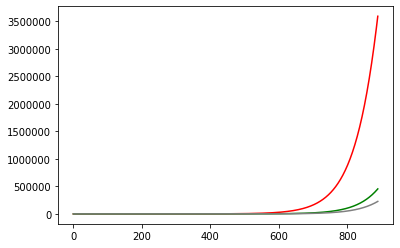

In [24]:
%%time
#Resolution using Fahd
tau = .1
x=np.linspace(tau,data.shape[1],int((data.shape[1])/tau))
y=fahd(fit_params,x,y0)

#Plot estimated data using odint
#plt.plot(y[0], label="Sr",color='blue')
plt.plot(y[1], label="Is",color='red')
plt.plot(y[2],label="Rs", color='green')
plt.plot(y[3],label="Ds", color='gray')

CPU times: user 59.6 ms, sys: 3.97 ms, total: 63.5 ms
Wall time: 67.4 ms


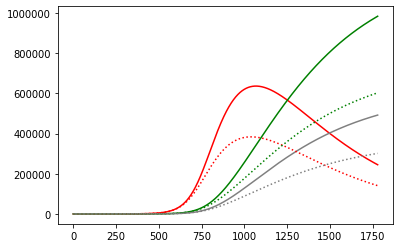

In [25]:
%%time
#Resolution using odint
p=1
tau = .1
x=np.linspace(tau,data.shape[1]*2,int((data.shape[1]*2)/tau))
fit_params['p'].value=60
y=f(fit_params,x,y0)
#Plot estimated data using odint
plt.plot(y[1], label="Is",color='red')
plt.plot(y[2],label="Rs", color='green')
plt.plot(y[3],label="Ds", color='gray')

fit_params['p'].value=100
y=f(fit_params,x,y0)
#Plot estimated data using odint
plt.plot(y[1], linestyle='dotted',label="Is",color='red')
plt.plot(y[2],linestyle='dotted',label="Rs", color='green')
plt.plot(y[3],linestyle='dotted',label="Ds", color='gray')

In [26]:
#Algorithm de l'article de Mr Karami
def fahdFix(params,x,y0):
    n=x.size
    N= params["N"]
    pp= params["p"].value
    beta= params["beta"].value
    gamma= params["gamma"].value
    sigma= params["sigma"].value
    tau=x[1]-x[0]
    S=np.empty(n+1)
    I=np.empty(n+1)
    R=np.empty(n+1)
    D=np.empty(n+1)
    P=np.ones(n+1)
    for i in range(tc,tc+eps+1):
      P[i]=1+(pp-1)*(i-tc)/eps 
    for i in range(tc+eps+1,n+1):
      P[i]=pp 
    S[0]=y0[0]
    I[0]=y0[1]
    R[0]=y0[2]
    D[0]=y0[3]
    theta=(S[0]/N)**(P[0]-1)
    for k in range(n):
        Err=1
        II=I[k]
        theta=(S[k]/N)**(P[k]-1)
        while Err>1e-10:
            root=np.sqrt((tau*(gamma+sigma)+1.-tau*(beta/N)*(S[k]+I[k])*theta)**2+(4*tau*(beta/N)*(tau*(gamma+sigma)+1)*theta*I[k]))
            rest=(tau*(gamma+sigma)+1)-tau*(beta/N)*(S[k]+I[k])*theta
            den=2*tau*(beta/N)*(1.+tau*(gamma+sigma))*theta
            III=(root-rest)/den
            SS=S[k]/(1.+(tau*(beta/N)*III*theta))
            RR=R[k]+tau*gamma*III
            DD=D[k]+tau*sigma*III
            theta1=(SS/N)**(P[k+1]-1)
            #Err=abs(II-III)
            Err=abs(theta-theta1)
            II=III
            theta=theta1
            #print(Err)
        S[k+1],I[k+1],R[k+1],D[k+1]=SS,II,RR,DD
        #print("===========================================================================")
    S=S[1:].tolist()
    I=I[1:].tolist()
    R=R[1:].tolist()
    D=D[1:].tolist()
    return np.array([S,I,R,D])

CPU times: user 485 ms, sys: 0 ns, total: 485 ms
Wall time: 492 ms


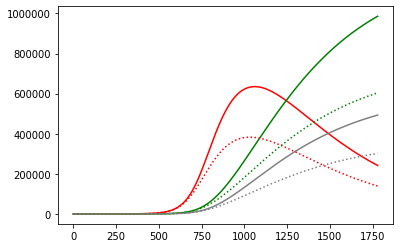

In [27]:
%%time
#Resolution using fahdFix
tau=0.1
x=np.linspace(tau,data.shape[1],int((data.shape[1])/tau))
tc=int(30/tau)#confinement
eps=10
n=x.size

x=np.linspace(tau,data.shape[1]*2,int((data.shape[1]*2)/tau))
fit_params['p'].value=60
y=fahdFix(fit_params,x,y0)
#Plot estimated data using odint
plt.plot(y[1], label="Is",color='red')
plt.plot(y[2],label="Rs", color='green')
plt.plot(y[3],label="Ds", color='gray')

fit_params['p'].value=100
y=fahdFix(fit_params,x,y0)
#Plot estimated data using odint
plt.plot(y[1], linestyle='dotted',label="Is",color='red')
plt.plot(y[2],linestyle='dotted',label="Rs", color='green')
plt.plot(y[3],linestyle='dotted',label="Ds", color='gray')

In [28]:
def objective(params,f,x,data,y0):
    # Initial number of infected and recovered individuals, I0 and R0.
    ndata, _ = data.shape
    resid = 0.0*data[:]
    ret=f(params,x,y0)
    
    for i in range(ndata):
        resid[i, :] =data[i, :] - ret[i,:]#/(1e-5+data[i, :])
    return resid.flatten()


[    1     1     1     2     2     2     2     2     3     5     6     7
    17    28    29    38    49    63    77    96   115   143   170   225
   275   345   402   479   556   617   654   708   791   919  1021  1120
  1184  1275  1374  1448  1545  1661  1763  1888  2024  2283  2564  2685
  2855  3046  3209  3446  3568  3758  3897  4065  4120  4252  4321  4423
  4569  4729  4903  5053  5219  5408  5548  5711  5910  6063  6281  6418
  6512  6607  6652  6741  6870  6952  7023  7133  7211  7332  7406  7433
  7532  7577  7601  7643  7714  7780  7807  7833  7866  7922  8003  8071
  8151  8224  8302  8437  8508  8537  8610  8692  8793  8885  8931  8997
  9074  9613  9839  9977 10172]
[[Variables]]
    N:      3.689e+07 (fixed)
    p:      1 (fixed)
    beta:   1.17956023 +/- 0.18292108 (15.51%) (init = 0.2)
    gamma:  0.99999852 +/- 0.15067273 (15.07%) (init = 0.02)
    sigma:  0.11983565 +/- 0.05354359 (44.68%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(be

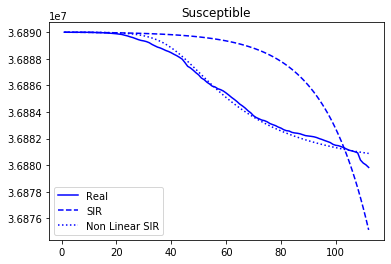

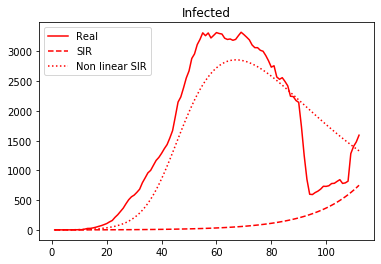

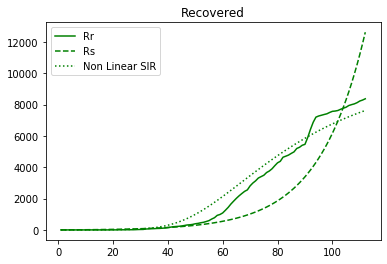

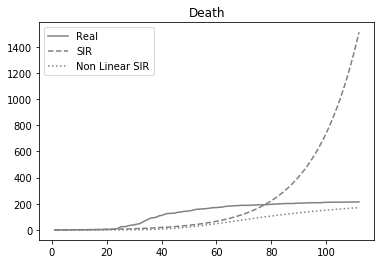

In [29]:
z=[0.6,0.3,0.05,0.05]
#z=[0.9,0.033,0.033,0.034]
y0,data,ac=getCountryData("MA",N,113)
tc= 10                #26   said depart #confinement
eps=4                #2 said 
n=data.shape[1]
x=np.linspace(1,n,n)
fit_params["p"].value=1
fit_params["p"].vary=True
outf = minimize(objective, fit_params, nan_policy='omit', args=(fahdFix,x,data,y0))#method='Nelder-Mead',tol=1e-10,

fit_params["p"].value=1
fit_params["p"].vary=False
out = minimize(objective, fit_params, nan_policy='omit', args=(f,x,data,y0))

report_fit(out.params)
report_fit(outf.params)
y=f(out.params,x,[N-1,1,0,0])
yf=fahdFix(outf.params,x,[N-1,1,0,0])


plt.figure()
plt.plot(x,data[0],label="Real", color='blue')
plt.plot(x,y[0], label="SIR",linestyle='dashed',color='blue')
plt.plot(x,yf[0],label='Non Linear SIR', linestyle="dotted",color='blue')
plt.legend()
plt.title("Susceptible")
plt.savefig("Sresults.png", dpi=150)

plt.figure()
plt.plot(x,data[1],label="Real", color='red')
plt.plot(x,y[1], label="SIR",linestyle='dashed',color='red')
plt.plot(x,yf[1],linestyle='dotted', label="Non linear SIR",color='red')
plt.legend()
plt.title("Infected")
plt.savefig("Iresults.png", dpi=150)

plt.figure()
plt.plot(x,data[2],label="Rr", color='green')
plt.plot(x,y[2],label="Rs",linestyle='dashed', color='green')
plt.plot(x,yf[2],linestyle='dotted',label="Non Linear SIR", color='green')
plt.legend()
plt.title("Recovered")
plt.savefig("Rresults.png", dpi=150)

plt.figure()
plt.plot(x,data[3],label="Real", color='gray')
plt.plot(x,y[3],label="SIR",linestyle='dashed', color='gray')
plt.plot(x,yf[3],linestyle='dotted',label="Non Linear SIR", color='gray')
plt.legend()
plt.title("Death")
plt.savefig("Dresults.png", dpi=150)




112
1.05333472803661 4.4562551653666125


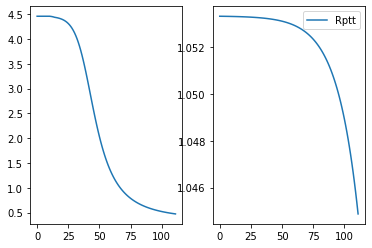

In [30]:
R00=out.params["beta"].value/(out.params["sigma"].value+out.params["gamma"].value)
R0=outf.params["beta"].value/(outf.params["sigma"].value+outf.params["gamma"].value)

n=x.size
print(n)
pp=outf.params["p"].value
P=np.ones(n)
for i in range(tc,tc+eps+1):
  P[i]=1+(pp-1)*(i-tc)/eps 
for i in range(tc+eps+1,n):
  P[i]=pp 
rt=R0*(yf[0]/N)**P
rtt=R00*(y[0]/N)**20
plt.figure()
plt.subplot(1, 2, 1)
plt.plot(rt,label='Rpt')
plt.subplot(1, 2, 2)
plt.plot(rtt,label='Rptt')
print(R00, R0)
plt.legend()


# Etape1:
Teste 1:  
presentation du caractère exponentielle dans les premiers 15 jours 
de l'épédimie  par paquet (Italy espagne france allemagne ) +(maroc algérie egypte afrique du sud) +(Chilie brazil mexique iran)

mettre en evidence le caractère exponenetille de l'épedemie







[   1    1    1    2    2    2    2    2    3    5    6    7   17   28
   29   38   49   63   77   96  115  143  170  225  275  345  402  479
  556  617  654  708  791  919 1021 1120 1184 1275 1374 1448 1545 1661
 1763 1888 2024 2283 2564 2685 2855 3046 3209 3446 3568 3758 3897 4065
 4120 4252 4321 4423 4569 4729 4903 5053 5219 5408 5548 5711 5910 6063
 6281 6418 6512 6607 6652 6741 6870 6952 7023 7133 7211 7332 7406 7433
 7532 7577 7601 7643 7714 7780 7807 7833 7866 7922 8003 8071 8151 8224
 8302 8437]
[   1    1    1    1    1    1    3    5   12   12   17   17   19   20
   20   20   24   26   37   48   54   60   74   87   90  139  201  230
  264  302  367  409  454  511  584  716  847  986 1171 1251 1320 1423
 1468 1572 1666 1761 1825 1914 1983 2070 2160 2268 2418 2534 2629 2718
 2811 2910 3007 3127 3256 3382 3517 3649 3848 4006 4154 4295 4474 4648
 4838 4997 5182 5369 5558 5723 5891 6067 6253 6442 6629 6821 7019 7201
 7377 7542 7728 7918 8113 8306 8503 8697 8857 8997 9134 9267 9394

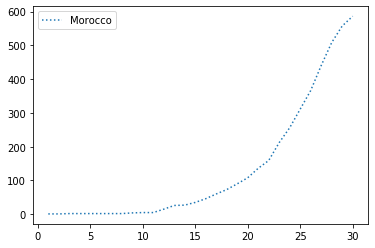

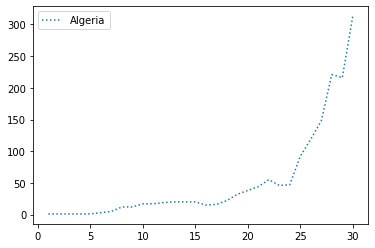

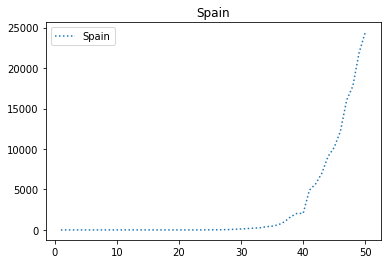

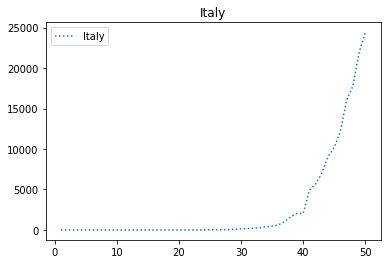

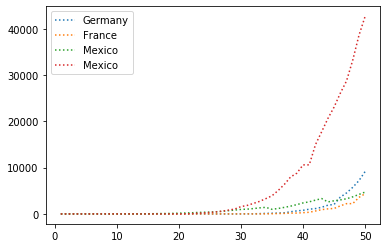

In [31]:
fit_params["p"].value=1
fit_params["p"].vary=False
m=100
y0MA,dataMA,acMA=getCountryData("MA",Nma,m)
n=dataMA.shape[1]
n1=30
x=np.linspace(1,n1,n1)
#plt.subplot(3, 3, 1)
plt.figure()
#plt.plot(x,acMA[0:n1], label="Morocco")
plt.plot(x,dataMA[1][0:n1],linestyle="dotted", label="Morocco")
#plt.title("Morocco")
plt.legend()
plt.savefig("maExp.png", dpi=150)

y0Alg,dataAlg,acAlg=getCountryData("DZ",Nalg,m)
n=dataAlg.shape[1]
x=np.linspace(1,n1,n1)
#plt.subplot(3, 3, 2)
plt.figure()
#plt.plot(x,acAlg[0:n1], label="Algeria")
plt.plot(x,dataAlg[1][0:n1],linestyle="dotted", label="Algeria")
#plt.title("Algeria")
plt.legend()
plt.savefig("AlgExp.png", dpi=150)



n1=50
x=np.linspace(1,n1,n1)
plt.figure()

y0ES,dataES,acES=getCountryData("ES",Nsp,m)
n=dataES.shape[1]
#plt.plot(x,acES[0:n1], label="Spain")
plt.plot(x,dataES[1][0:n1], linestyle="dotted", label="Spain")
plt.title('Spain')
plt.legend()
plt.savefig("spExp.png", dpi=150)

plt.figure()

y0IT,dataIT,acIT=getCountryData("ES",Nsp,m)
n=dataIT.shape[1]
#plt.plot(x,acES[0:n1], label="Spain")
plt.plot(x,dataIT[1][0:n1], linestyle="dotted", label="Italy")
plt.title('Italy')
plt.legend()
plt.savefig("itExp.png", dpi=150)


y0DE,dataDE,acDE=getCountryData("DE",Nde,m)
n=dataDE.shape[1]
#plt.subplot(3, 3, 5)
plt.figure()
#plt.plot(x,acDE[0:n1], label="Germany")
plt.plot(x,dataDE[1][0:n1],linestyle="dotted",  label="Germany")
#plt.title('Germany')
plt.legend()
plt.savefig("germExp.png", dpi=150)

y0Fr,dataFr,acFr=getCountryData("FR",Nfr,m)
n=dataFr.shape[1]
x=np.linspace(1,n1,n1)
#plt.subplot(3, 3, 3)
#plt.figure()
#plt.plot(x,acFr[0:n1], label="France")
plt.plot(x,dataFr[1][0:n1],linestyle="dotted",  label="France")
#plt.title("France")
plt.legend()
plt.savefig("frExp.png", dpi=150)

y0MX,dataMX,acMX=getCountryData("MX",Nmx,m)
n=dataMX.shape[1]
#x=np.linspace(1,n1,n1)
#plt.subplot(3, 3, 6)
#plt.figure()
#plt.plot(x,acMX[0:n1], label="Mexico")
plt.plot(x,dataMX[1][0:n1],linestyle="dotted",  label="Mexico")
#plt.title("Mexico")
plt.legend()
plt.savefig("mexExp.png", dpi=150)

y0IT,dataIT,acIT=getCountryData("IT",Nit,m)
n=dataIT.shape[1]
#x=np.linspace(1,n1,n1)
#plt.subplot(3, 3, 6)
#plt.figure()
#plt.plot(x,acMX[0:n1], label="Mexico")
plt.plot(x,dataIT[1][0:n1],linestyle="dotted",  label="Mexico")
#plt.title("Mexico")
plt.legend()
plt.savefig("itExp.png", dpi=150)


[  444   444   549   761  1058  1423  3554  3554  4903  5806  7153 11177
 13522 16678 19665 22112 24953 27100 29631 31728 33366 33366 48206 54406
 56249 58182 59989 61682 62031 62442 62662 64084 64084 64287 64786 65187
 65596 65914 66337 66907 67103 67217 67332 67466 67592 67666 67707 67743
 67760 67773 67781 67786 67790 67794 67798 67799 67800 67800 67800 67800
 67800 67800 67801 67801 67801 67801 67801 67801 67801 67801 67802 67802
 67802 67803 67803 67803 67803 67803 67803 67803 67803 67803 67803 67803
 67803 67803 68128 68128 68128 68128 68128 68128 68128 68128 68128 68128
 68128 68128 68128 68128]
(4, 99)


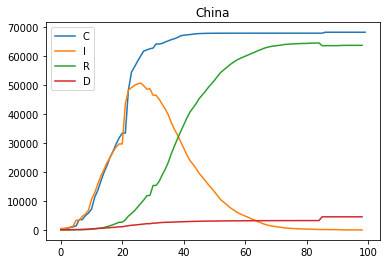

In [32]:
y0CH,dataCH,acCH=getCountryData("china",Nch,m)
n=dataCH.shape[1]
print(dataCH.shape)
x=np.linspace(1,n,n)
#plt.subplot(3, 3, 6)
plt.figure()
plt.plot(acCH,label="C")
plt.plot(dataCH[1], label="I")
plt.plot(dataCH[2], label="R")
plt.plot(dataCH[3], label="D")
plt.title("China")
plt.legend()
plt.savefig("wuhan.png", dpi=150)


#Etape 2:
Test2: lancer SIR classique sur les premiers 15 jours, fitter sur les données, recuperer $ \alpha, \beta, et \gamma $ en suite tracer les courbes SIR et les SIRP en variant les p $p=10 , 100, 50000$
L'impact de $p$ est du confinement  et l et voir  l impact de la puissance 





[[Variables]]
    N:      6.0464e+07 (fixed)
    p:      1 (fixed)
    beta:   0.25495750 +/- 0.00705929 (2.77%) (init = 0.2)
    gamma:  0.03230210 +/- 0.00592673 (18.35%) (init = 0.02)
    sigma:  0.02644161 +/- 0.00585988 (22.16%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, gamma)  =  0.635
    C(beta, sigma)  =  0.625
    C(gamma, sigma) = -0.205


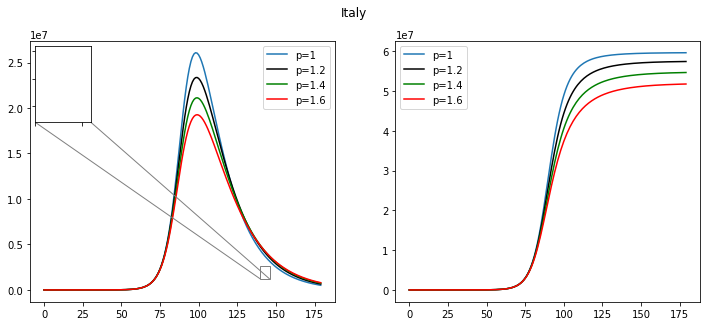

In [33]:
def pEffect(data,N,tc,tmax,y0):   
    fit_params["N"].value=N
    fit_params["p"].value=1
    fit_params["p"].vary=False
    n1=tc #46
    x=np.linspace(1,n1,n1)
    d=np.array([data[0][0:n1],data[1][0:n1],data[2][0:n1],data[3][0:n1]])
    #print(d.shape)
    out = minimize(objective, fit_params,  args=(f,x,d,y0))
    report_fit(out.params)
    n1=tmax #180
    x=np.linspace(1,n1,n1)
    out.params["p"].value=1
    y=f(out.params,x,[N-1,1,0,0])
    out.params["p"].value=1.2
    yf1=f(out.params,x,[N-1,1,0,0])
    out.params["p"].value=1.4
    yf2=f(out.params,x,[N-1,1,0,0])
    out.params["p"].value=1.6
    yf3=f(out.params,x,[N-1,1,0,0])
    
    from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
    
    fig, ax = plt.subplots(1, 2,sharex=True,figsize=[12, 4.8])
    axins= zoomed_inset_axes(ax[0],6, loc=2)
    ax[0].plot(y[1],label="p=1")
    ax[0].plot(yf1[1],color="black",label="p=1.2")
    ax[0].plot(yf2[1],color="green",label="p=1.4")
    ax[0].plot(yf3[1],color="red",label="p=1.6")
    #ax.plot(N-yf3[0],label="p=1.6")
    
    
    axins.plot(y[1],label="p=1")
    axins.plot(yf1[1],color="black",label="p=1.2")
    axins.plot(yf2[1],color="green",label="p=1.4")
    axins.plot(yf3[1],color="red",label="p=1.6")
    
    #x1, x2, y1, y2 = 162, 180, 0.15e7, 0.3e7 # Morocco
    #x1, x2, y1, y2 = 62, 80, 0.15e7, 0.3e7 # Morocco
    #x1, x2, y1, y2 = 178, 184, 0.12e7, 0.2e7 # gyrmany
    #x1, x2, y1, y2 = 196, 204, 0.1e7, 0.2e7 # France
    #x1, x2, y1, y2 = 150, 156, 0.07e7, 0.12e7 # Spain
    x1, x2, y1, y2 = 140, 146, 0.12e7, 0.26e7 # Italy
    #x1, x2, y1, y2 = 245, 256, 0.12e4, 0.426e5 # Spain
    axins.set_xlim(x1, x2) # apply the x-limits
    axins.set_ylim(y1, y2) # apply the y-limits[0,0][0,0]
    
    plt.yticks(visible=False)
    plt.xticks(visible=False)
    
    from mpl_toolkits.axes_grid1.inset_locator import mark_inset
    mark_inset(ax[0], axins, loc1=3, loc2=4, fc="none", ec="0.5")

    ax[0].legend()
    #ax.set_title("Italy")

    #plt.figure()
    ax[1].plot(N-y[0],label="p=1")
    ax[1].plot(N-yf1[0],color="black",label="p=1.2")
    ax[1].plot(N-yf2[0],color="green",label="p=1.4")
    ax[1].plot(N-yf3[0],color="red",label="p=1.6")
    
    ax[1].legend()
    fig.suptitle("Italy")
    fig.savefig("pEffectIT_zoom.png", dpi=150)
    
#pEffect(dataMA,Nma,46,240,y0MA)  
#pEffect(dataDE,Nde,70,200,y0DE) 
#pEffect(dataFr,Nfr,70,220,y0Fr) 
#pEffect(dataES,Nsp,60,180,y0ES) 
pEffect(dataIT,Nit,55,180,y0IT) 
#pEffect(dataAlg,Nit,20,100,y0IT)

# Etape3
Dans le test 3 on fit notre modèle et nous recuperons les nouveaux parametre $\alpha, \beta, \gamma et p $.
Nous fittons egalement SIR.

Comparer d'abord fitting de notre modele et du modèle SIR.
mettre en evidence que le fitting avec notre modèle donne meilleure resultasts vu qu il prend en considération la distanciation social( indicateur de fitting).
(Donner plus d'importance et donnée recente)


Tracer le $R_p(t)$ pour chaque pays 

Mesuré l'impact du confinement en comparant notre modèle  avec (SIR avec les parametres $(\alpha, \beta, \gamma)$ de l'etape 2)

Italy tc: 40 eps: 10
===============SIR==================
[[Variables]]
    N:      6.0464e+07 (fixed)
    p:      1 (fixed)
    beta:   0.29094205 +/- 0.03202622 (11.01%) (init = 0.2)
    gamma:  0.12574987 +/- 0.02390627 (19.01%) (init = 0.02)
    sigma:  0.05079036 +/- 0.01756893 (34.59%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, gamma)  =  0.859
    C(beta, sigma)  =  0.723
    C(gamma, sigma) =  0.268
None
===============SIR FahdFix==================
[[Variables]]
    N:      6.0464e+07 (fixed)
    p:      699.252518 +/- 2.64179421 (0.38%) (init = 1)
    beta:   0.21531533 +/- 2.1562e-04 (0.10%) (init = 0.2)
    gamma:  0.01863254 +/- 1.3475e-04 (0.72%) (init = 0.02)
    sigma:  0.00757265 +/- 1.1561e-04 (1.53%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(p, gamma)    = -0.483
    C(p, sigma)    = -0.418
    C(beta, sigma) =  0.298
    C(p, beta)     =  0.274
    C(beta, gamma) =  0.217
None


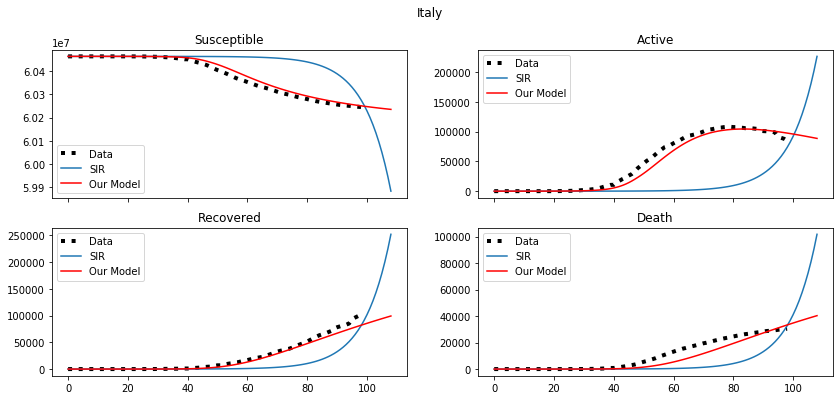

In [34]:
tc= 40               #Morocco
eps=10

def result(country,data,y0,N):
  print(country,"tc:",tc,"eps:",eps)
  n=data.shape[1]
  n1=n
  x=np.linspace(1,n1,n1)
  d=np.array([data[0][0:n1],data[1][0:n1],data[2][0:n1],data[3][0:n1]])
  #print(d.shape)
  fit_params["N"].value=N
  fit_params["p"].value=1
  fit_params["p"].vary=False
  out = minimize(objective, fit_params,  args=(f,x,data,y0))

  fit_params["p"].value=1
  fit_params["p"].vary=True
  outf = minimize(objective, fit_params,  args=(fahdFix,x,data,y0))

  print("===============SIR==================")
  print(report_fit(out.params))
  print("===============SIR FahdFix==================")
  print(report_fit(outf.params))
  print("====================================")
  out.params["p"].value=1
  x=np.linspace(1,n+10,n+10)
  y=f(out.params,x,[N-1,1,0,0])
  yf=fahdFix(outf.params,x,[N-1,1,0,0])

  #plt.figure(country)

  fig, axs= plt.subplots(2, 2,sharex=True,figsize=[14, 6])
  fig.suptitle(country)
  
  axs[0, 0].set_title('Susceptible')
  axs[0, 0].plot(d[0],linestyle="dotted",linewidth=4,color="black", label="Data")
  #axs[0, 0].scatter(x,d[0],linestyle="dotted",color="black", label="Real")
  axs[0, 0].plot(y[0],color="C10",label="SIR")
  axs[0, 0].plot(yf[0],color="red",label="Our Model")
  axs[0, 0].legend()
  
  axs[0, 1].set_title('Active')
  axs[0, 1].plot(d[1],linestyle="dotted",linewidth=4,color="black", label="Data")
  axs[0, 1].plot(y[1],color="C10",label="SIR")
  axs[0, 1].plot(yf[1],color="red",label="Our Model")  
  axs[0, 1].legend()

  axs[1, 0].set_title('Recovered')
  axs[1, 0].plot(d[2],linestyle="dotted",linewidth=4,color="black", label="Data")
  axs[1, 0].plot(y[2],color="C10",label="SIR")
  axs[1, 0].plot(yf[2],color="red",label="Our Model")
  axs[1, 0].legend()
    
  axs[1, 1].set_title('Death')
  axs[1, 1].plot(d[3],linestyle="dotted",linewidth=4,color="black", label="Data")
  axs[1, 1].plot(y[3],color="C10",label="SIR")
  axs[1, 1].plot(yf[3],color="red",label="Our Model")
  axs[1, 1].legend()
  fig.savefig("resultIT.png", dpi=150)

#result("Morocco",dataMA,y0MA,Nma)
#result("Algeria",dataAlg,y0Alg,Nalg)
#result("Spain",dataES,y0ES,Nsp)
#result("Mexico",dataMX,y0MX,Nmx)
#result("Germany",dataDE,y0DE,Nde)
#result("France",dataFr,y0Fr,Nfr)
result("Italy",dataIT,y0IT,Nit)